# Insertion algorithm 

In [1]:
%matplotlib inline

import torch
import numpy as np
import signatory
import math

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from insertion import Insertion, get_A_matrix, solve_optimization_problem,invert_signature
from tools import get_signature_as_tensor


In [2]:
test_tensor = torch.rand((3,3,3))
print(test_tensor[0,1,2])

tensor(0.2730)


## Insertion operator 

In [3]:
test_path = torch.rand((1,10,5))
signature_test = signatory.signature(test_path, 2)
get_signature_as_tensor(signature_test,5,2)

{'Depth 1': tensor([-0.1085,  0.0015, -0.4854,  0.2756, -0.8251]),
 'Depth 2': tensor([[ 5.8809e-03, -1.4333e-01, -1.3180e-01, -1.3623e-01,  2.1232e-01],
         [ 1.4317e-01,  1.1399e-06,  2.5032e-01,  2.2726e-01,  1.1257e-01],
         [ 1.8444e-01, -2.5105e-01,  1.1780e-01, -4.4535e-02,  6.7355e-01],
         [ 1.0634e-01, -2.2684e-01, -8.9229e-02,  3.7972e-02, -1.1931e-01],
         [-1.2283e-01, -1.1380e-01, -2.7304e-01, -1.0808e-01,  3.4042e-01]])}

In [4]:
x=[1,2,3,4,5]

p=3

n=2

dimension=5

Insertion(p,n,x,signature_test,dimension)

tensor([[[ 1.1762e-02,  2.3524e-02,  3.5285e-02,  4.7047e-02,  5.8809e-02],
         [-2.8667e-01, -5.7334e-01, -8.6000e-01, -1.1467e+00, -1.4333e+00],
         [-2.6361e-01, -5.2721e-01, -7.9082e-01, -1.0544e+00, -1.3180e+00],
         [-2.7246e-01, -5.4492e-01, -8.1737e-01, -1.0898e+00, -1.3623e+00],
         [ 4.2464e-01,  8.4928e-01,  1.2739e+00,  1.6986e+00,  2.1232e+00]],

        [[ 2.8634e-01,  5.7268e-01,  8.5903e-01,  1.1454e+00,  1.4317e+00],
         [ 2.2799e-06,  4.5598e-06,  6.8396e-06,  9.1195e-06,  1.1399e-05],
         [ 5.0064e-01,  1.0013e+00,  1.5019e+00,  2.0026e+00,  2.5032e+00],
         [ 4.5451e-01,  9.0902e-01,  1.3635e+00,  1.8180e+00,  2.2726e+00],
         [ 2.2513e-01,  4.5026e-01,  6.7539e-01,  9.0053e-01,  1.1257e+00]],

        [[ 3.6889e-01,  7.3778e-01,  1.1067e+00,  1.4756e+00,  1.8444e+00],
         [-5.0210e-01, -1.0042e+00, -1.5063e+00, -2.0084e+00, -2.5105e+00],
         [ 2.3561e-01,  4.7121e-01,  7.0682e-01,  9.4243e-01,  1.1780e+00],
        

In [7]:
dimension=4
test_path = torch.rand((1,10,dimension))
n=4
signature_test = signatory.signature(test_path, n)
last_signature_term = get_signature_as_tensor(signature_test,dimension,n)["Depth "+ str(n)]
p=3

# Test if A has the right structure: A^TA should be diagonal with same values in the diagonal.
A_matrix=get_A_matrix(p,signature_test,n,dimension)
print(np.matmul(np.transpose(A_matrix),A_matrix))

tensor(1.9176)
tensor([[672.1524,   0.0000,   0.0000,   0.0000],
        [  0.0000, 672.1524,   0.0000,   0.0000],
        [  0.0000,   0.0000, 672.1524,   0.0000],
        [  0.0000,   0.0000,   0.0000, 672.1524]], dtype=torch.float64)


In [8]:
signature = signatory.signature(test_path, 2)
signature_next = signatory.signature(test_path,3)

solve_optimization_problem(signature, signature_next,p=2,n=2,dimension=2)

tensor(0.9719)


array([-0.96763261, -0.25236309])

## Tests

### Tests on semi-circle 

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


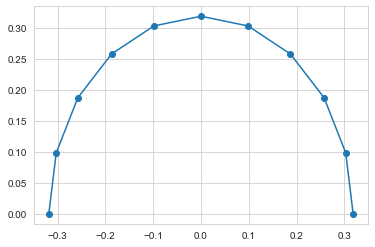

In [9]:
points = np.arange(0,1.1,0.1)

print(points)
x1 = 1/(math.pi)*np.cos(math.pi*points)

x2 = 1/(math.pi)*np.sin(math.pi*points)

sns.set_style('whitegrid')

plt.plot(x1,x2,linestyle='-',marker='o')
plt.show()

tensor(0.8700, dtype=torch.float64)
tensor(0.8700, dtype=torch.float64)
tensor(0.8700, dtype=torch.float64)
tensor(0.8700, dtype=torch.float64)
tensor(0.8700, dtype=torch.float64)


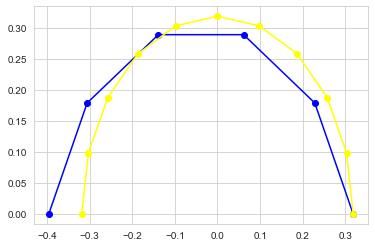

In [10]:
path = torch.tensor(np.array((x1,x2)).T)
n=4

signature = signatory.signature(path.unsqueeze(0), n+1)

reconstructed_path=invert_signature(signature,n,path[0,:],2)
plt.plot(reconstructed_path[:,0],reconstructed_path[:,1],c='blue',marker='o')
plt.plot(path[:,0],path[:,1],linestyle='-',marker='o',c='yellow')
plt.show()

    

## Pendigits example

In [11]:
from get_data import get_pendigits

X,y=get_pendigits()

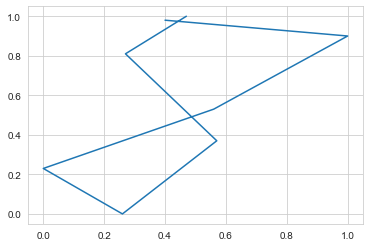

In [16]:
path=torch.tensor(X[0,:,:])/100

plt.plot(path[:,0],path[:,1])

torch.Size([8, 2])
tensor(2.1832, dtype=torch.float64)
tensor(2.1832, dtype=torch.float64)
tensor(2.1832, dtype=torch.float64)
tensor(2.1832, dtype=torch.float64)
tensor(2.1832, dtype=torch.float64)
tensor(2.1832, dtype=torch.float64)
tensor(2.1832, dtype=torch.float64)
tensor(2.1832, dtype=torch.float64)
tensor(2.1832, dtype=torch.float64)
tensor(2.1832, dtype=torch.float64)


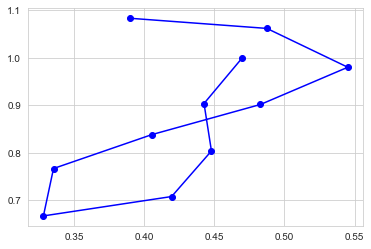

In [17]:
n=9
print(path.shape)

signature = signatory.signature(path.unsqueeze(0), n+1)

reconstructed_path=invert_signature(signature,n,path[0,:],2)

plt.plot(reconstructed_path[:,0],reconstructed_path[:,1],c='blue',marker='o')
#plt.plot(path[:,0],path[:,1],linestyle='-',marker='o',c='yellow')
plt.show()
    

## Other tests

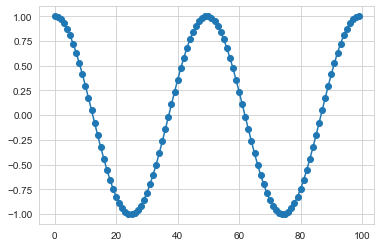

In [55]:
time=np.linspace(0,1,num=100)

path=torch.tensor(np.transpose(np.array([np.cos(4*math.pi*time),time])))

plt.plot(path[:,0],linestyle='-',marker='o')
plt.show()

In [56]:
n=11

signature = signatory.signature(path.unsqueeze(0), n+1)
print(signature.shape)

reconstructed_path=invert_signature(signature,n,path[0,:],2)

torch.Size([1, 8190])
tensor(4.1136, dtype=torch.float64)
tensor(4.1136, dtype=torch.float64)
tensor(4.1136, dtype=torch.float64)
tensor(4.1136, dtype=torch.float64)
tensor(4.1136, dtype=torch.float64)
tensor(4.1136, dtype=torch.float64)
tensor(4.1136, dtype=torch.float64)
tensor(4.1136, dtype=torch.float64)
tensor(4.1136, dtype=torch.float64)
tensor(4.1136, dtype=torch.float64)
tensor(4.1136, dtype=torch.float64)
tensor(4.1136, dtype=torch.float64)


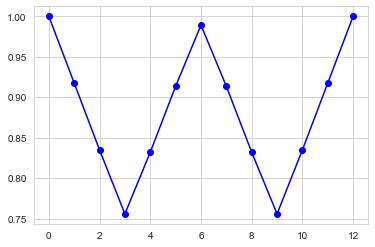

In [57]:
plt.plot(reconstructed_path[:,0],c='blue',marker='o')
#plt.plot(path[:,0],path[:,1],linestyle='-',marker='o',c='yellow')
plt.show()
    

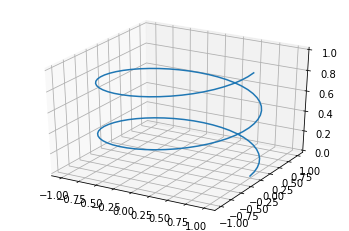

In [3]:
from mpl_toolkits.mplot3d import Axes3D

time=np.linspace(0,1,num=100)

path=torch.tensor(np.transpose(np.array([np.cos(4*math.pi*time),np.sin(4*math.pi*time),time])))
#path=torch.cat((path,path))
#path=torch.cat((path,torch.flip(path,[0])))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(path[:,0],path[:,1],path[:,2],linestyle='-')
plt.show()

In [4]:
n=8

signature = signatory.signature(path.unsqueeze(0), n+1)
print(signature.shape)

reconstructed_path=invert_signature(signature,n,path[0,:],3)

torch.Size([1, 29523])


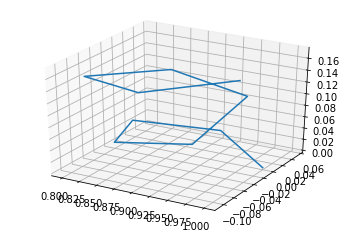

In [6]:
#plt.plot(reconstructed_path[:,0],reconstructed_path[:,1],linestyle='-',marker='o')
#plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(reconstructed_path[:,0],reconstructed_path[:,1],reconstructed_path[:,2],linestyle='-')
plt.show()

torch.Size([100, 4])


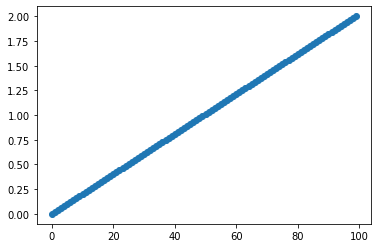

In [2]:
time=np.linspace(0,1,num=100)

path=torch.tensor(np.transpose(np.array([time*2,time,time*5,time*9])))

print(path.shape)
plt.plot(path[:,0],linestyle='-',marker='o')
plt.show()

In [12]:
n=5
print(path.unsqueeze(0).shape)
signature = signatory.signature(path.unsqueeze(0), n+1)
print(signature.shape)

reconstructed_path=invert_signature(signature,n,path[0,:],4)

torch.Size([1, 100, 4])
torch.Size([1, 5460])


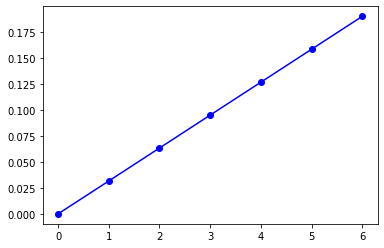

In [13]:
plt.plot(reconstructed_path[:,0],c='blue',marker='o')
#plt.plot(path[:,0],path[:,1],linestyle='-',marker='o',c='yellow')
plt.show()
    